<a href="https://colab.research.google.com/github/Praveen76/Text-Classification-using-NaiveBayes-Classifier/blob/main/Text_Classification_using_NaiveBayes_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning Objectives

At the end of the experiment, you will be able to:

* perform different text processing techniques such as removing html strips and noise text, removing special characters, lemmatization, stemming, tokenization, removing stop words
* train and evaluate a Naive Bayes model from the sklearn ML library, to predict the sentiment ('positive' or 'negative') for a movie reviews dataset
* use the gradio library  to generate a customizable UI for displaying the predictions


## Dataset description

The [IMDB Movie Reviews dataset](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) is a binary sentiment analysis dataset consisting of 50,000 reviews from the Internet Movie Database (IMDb) labeled as positive or negative. The dataset contains an even number of positive and negative reviews. Only highly polarizing reviews are considered. A negative review has a score ≤ 4 out of 10, and a positive review has a score ≥ 7 out of 10. No more than 30 reviews are included per movie. The dataset contains additional unlabeled data.

### Importing Required Packages

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer                        # to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text
from sklearn.feature_extraction.text import TfidfVectorizer                        # to transform text into a term and document frequency based representation of numbers
import nltk                                                                        # platform for building Python programs to process natural language
nltk.download('stopwords')                                                         # to download the stop words
nltk.download('punkt')                                                             # tokenizer divides a text into a list of sentences, by using an unsupervised algorithm to build a model for abbreviation words, collocations, and words that start sentences
nltk.download('wordnet')                                                           # to lemmatize word using WordNet's built-in function
from nltk.corpus import stopwords                                                  # importing the NTLK stopwords to remove articles, preposition and other words that are not actionable
from nltk.stem.porter import PorterStemmer                                         # process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
from wordcloud import WordCloud                                                    # visualization of words based on their frequency
from nltk.tokenize import word_tokenize                                            # allows to create individual objects from a bag of words
from bs4 import BeautifulSoup                                                      # Python library for pulling data from HTML and XML files
import re                                                                          # regular expression (or RE) specifies a set of strings that matches it
from sklearn.naive_bayes import MultinomialNB                                      # to import multinomial naive bayes which is suitable for classification with discrete features (e.g., word counts for text classification)
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score  # to import metrics for evaluating the classification model
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### Load the dataset

In [ ]:
import yaml
import json

from google.colab import drive

# Mount Google Drive with force remount
drive.mount('/content/drive', force_remount=True)

# Load relevant API Keys
file_path = '/content/drive/MyDrive/.API_KEYS/API_KEYS.yml'

with open(file_path, 'r') as file:
    api_keys = yaml.safe_load(file)


# Extract Kaggle username and key
aws_access_key_id = api_keys['AWS']['AWS_ACCESS_KEY_ID']
aws_secret_access_key = api_keys['AWS']['AWS_SECRET_ACCESS_KEY']


Mounted at /content/drive


In [ ]:
import os
os.environ['AWS_ACCESS_KEY_ID']=aws_access_key_id
os.environ['AWS_SECRET_ACCESS_KEY']=aws_secret_access_key

In [ ]:
!pip install awscli

!aws s3 cp s3://datasciencedataset/IMDB_Dataset.csv .


download: s3://datasciencedataset/IMDB_Dataset.csv to ./IMDB_Dataset.csv


In [ ]:
# read the dataset
df = pd.read_csv('IMDB_Dataset.csv')
print(df.shape)
df.head(10)      # first 10 rows

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


### Exploratory Data Analysis

In [ ]:
# summary of the dataset
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


Now, we will look at the sentiment count by category.

In [ ]:
# sentiment count
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

We can see that the dataset is balanced.

Now, we will do the text cleaning of the reviews.



### Text Cleaning

The data scraped from the website is mostly in the raw text form. This data needs to be cleaned before analyzing it or fitting a model to it. Cleaning up the text data is necessary to highlight the attributes that we are going to want our machine learning system to pick up on.

**Removing noisy text**

Sample noise removal tasks could include:

* removing text file headers, footers
* removing HTML, XML, etc. markup and metadata
* extracting valuable data from other formats, such as JSON

In [ ]:
# removing the html strips
def strip_html(text):
    # BeautifulSoup is a useful library for extracting data from HTML and XML documents
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

In [ ]:
# apply function on review column
df['review'] = df['review'].apply(denoise_text)

**Removing special characters**

Special characters typically include any character that is not a letter or number, such as punctuation. Removing special characters from a string results in a string containing only letters and numbers.

We can use the `re` python library for Regular expression operations.

To know more about Regular expressions, click [here](https://realpython.com/regex-python/).

In [ ]:
# define function for removing special characters
def remove_special_characters(text):
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern,'',text)
    return text

In [ ]:
# apply function on review column
df['review'] = df['review'].apply(remove_special_characters)

**Lemmatization**

Lemmatization is a text pre-processing technique used to break a word down to its root meaning or word (called lemme) to identify similarities.

For example, a lemmatization algorithm would reduce the word ***better*** to its root word, or lemme, ***good***.

In [ ]:
# Lemmatize word using WordNet's built-in function
# pos: The Part Of Speech tag.
#      Valid options are "n" for nouns, "v" for verbs, "a" for adjectives,
#                        "r" for adverbs and "s" for satellite adjectives.

lemmatizer = nltk.stem.WordNetLemmatizer()
print("better :", lemmatizer.lemmatize("better", pos ="a", ))

better : good


**Text Stemming**

Stemming, also called suffix stripping, is a technique used to reduce text dimensionality. Stemming is also a type of text normalization that enables you to standardize some words into specific expressions also called stems.

In [ ]:
# stemming the text
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [ ]:
# apply function on review column
df['review'] = df['review'].apply(simple_stemmer)

**Tokenization**

Tokenization is the process of splitting paragraphs and sentences into smaller understandable parts (words).

For example:

In [ ]:
word_tokenize('This is a test sentence.')

['This', 'is', 'a', 'test', 'sentence', '.']

**Removing stopwords**

Stopwords are English words that do not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc.

In [ ]:
# setting english stopwords
stopword_list = nltk.corpus.stopwords.words('english')
print(stopword_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

The above list of stopwords also contains the word "not", and its other forms such as don't, didn't, etc. We need them for correct sentiment classification.

For example, consider a negative review "*not a good movie*", and if we remove 'not' from it then it becomes a positive review "*a good movie*".

In [ ]:
# Exclude 'not' and its other forms from the stopwords list

updated_stopword_list = []

for word in stopword_list:
    if word=='not' or word.endswith("n't"):
        pass
    else:
        updated_stopword_list.append(word)

print(updated_stopword_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', '

In [ ]:
# removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    # splitting strings into tokens (list of words)
    tokens = word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        # filtering out the stop words
        filtered_tokens = [token for token in tokens if token not in updated_stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in updated_stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [ ]:
# apply function on review column
df['review'] = df['review'].apply(remove_stopwords)

After cleaning the reviews, we now split the clean dataset into training and testing set.

### Split into training and testing

**Parameters in train_test_split**

* arrays sequence of indexables with same length / shape (here, df.review and df.sentiment):
Allowed inputs are lists, numpy arrays, scipy-sparse matrices or pandas dataframes.

* test_size (float or int, default=None): The proportion of the dataset to include in the test split If train_size is also None, it will be set to 0.25.


* RandomState:
Controls the shuffling applied to the data before applying the split.

In [ ]:
# Split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(df.review, df.sentiment, test_size = 0.2, random_state = 0)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40000,)
(10000,)
(40000,)
(10000,)


Let us see positive and negative words by using **WordCloud**.

A word cloud (also called tag cloud or weighted list) is a visual representation of text data. Words are usually single words, and the importance of each is shown with font size or color.



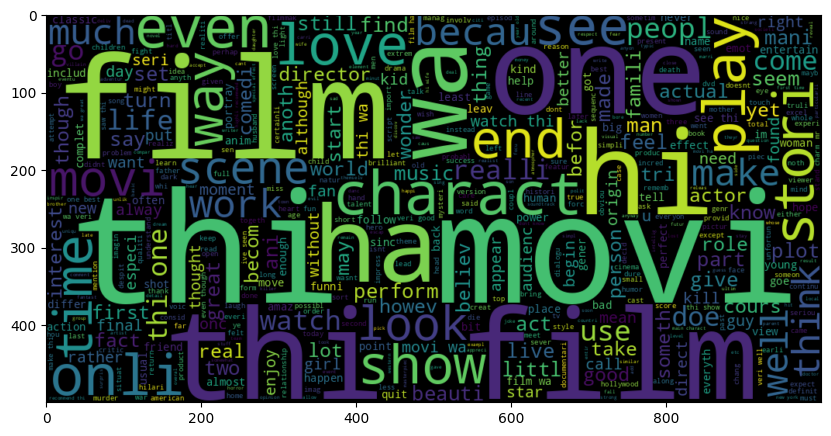

In [ ]:
# Word cloud for positive review words

plt.figure(figsize=(10,10))
df_positive_review =  df[df['sentiment']=='positive']
positive_text = ' '.join(review for review in df_positive_review.review)
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
positive_words = WC.generate(positive_text)
plt.imshow(positive_words, interpolation='bilinear')
plt.show()

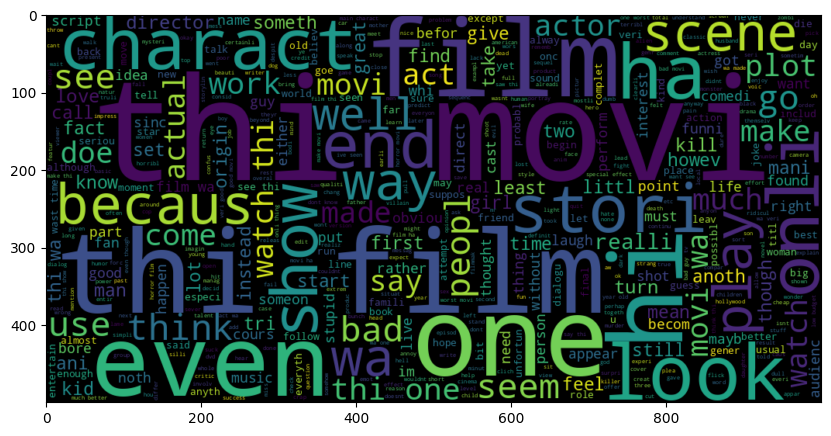

In [ ]:
# Word cloud for negative review words

plt.figure(figsize=(10,10))
df_negative_review =  df[df['sentiment']=='negative']
negative_text = ' '.join(review for review in df_negative_review.review)
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
negative_words = WC.generate(negative_text)
plt.imshow(negative_words, interpolation='bilinear')
plt.show()

## Converting Text into numerical feature vectors:

### 1. Bag of Words (based on word occurrence)

In order to perform machine learning on text documents, we first need to turn the text content into numerical feature vectors.

Bags of words is the most intuitive way to create such a representation:

Assign a fixed integer id to each word occurring in any document of the training set (for instance by building a dictionary from words to integer indices).

For each document $i$, count the number of occurrences of each word $w$ and store it in $X[i, j]$ as the value of feature $j$ where $j$ is the index of word $w$ in the dictionary.

The bags of words representation implies that n_features is the number of distinct words in the corpus.

<img src="https://cdn.iisc.talentsprint.com/AIandMLOps/Images/bag-of-words-example.png" width=500px>

#### Implementing Bag of Words using sklearn `Count Vectorizer`

The `CountVectorizer` provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary.

An encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document. The vectors returned from a call to transform() will be sparse vectors, and we can transform them back to numpy arrays to look and better understand what is going on by calling the `toarray()` function.

To know more about CountVectorizer, click [here](https://towardsdatascience.com/basics-of-countvectorizer-e26677900f9c).

In [ ]:
# Count vectorizer
cv = CountVectorizer(min_df=0, max_df=1, binary=False, ngram_range=(1,3))

# transformed train reviews
cv_train_reviews = cv.fit_transform(X_train)

# transformed test reviews
cv_test_reviews = cv.transform(X_test)

print('CV_train:', cv_train_reviews.shape)
print('CV_test:', cv_test_reviews.shape)

CV_train: (40000, 6206107)
CV_test: (10000, 6206107)


### 2. TF-IDF (based on word frequencies)

The issue with occurrence count is that longer documents will have higher average count values than shorter documents, even though they might talk about the same topics.

To avoid these potential discrepancies it suffices to divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called tf for Term Frequencies.

Another refinement on top of tf is to downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus.

This downscaling is called tf–idf for “Term Frequency times Inverse Document Frequency”.

#### Implementing TF-IDF with sklearn `TfidfVectorizer`

It is used to convert text documents to matrix of tf-idf features.

<img src="https://cdn.iisc.talentsprint.com/AIandMLOps/Images/tf-idf-formula.PNG" width=500px>


`TfidfVectorizer` is the base building block of many NLP pipelines. It is a simple technique to vectorize text documents — i.e. transform sentences into arrays of numbers — and use them in subsequent tasks.

To know more about tf-idf, click [here]( https://cdn.iisc.talentsprint.com/CDS/TF-IDF.pdf).

In [ ]:
# tfidf vectorizer
tv = TfidfVectorizer(min_df=0, max_df=1, use_idf=True, ngram_range = (1,3))
#transformed train reviews
tfidf_train_reviews = tv.fit_transform(X_train)
#transformed test reviews
tfidf_test_reviews = tv.transform(X_test)
print('Tfidf_train:', tfidf_train_reviews.shape)
print('Tfidf_test:', tfidf_test_reviews.shape)

Tfidf_train: (40000, 6206107)
Tfidf_test: (10000, 6206107)


### Modeling the data

**Naïve Bayes’ Classifier**

Bayesian network classifiers are a popular supervised
classification paradigm. The Naïve Bayes’ classifier is a probabilistic
classifier based on the Bayes’ theorem, considering a 'naive'
independence assumption.
It is a popular(baseline) method for text categorization, with word frequencies as the feature.

An advantage of Naïve Bayes’ is that it
only requires a small amount of training data to
estimate the parameters necessary for classification. Despite its simplicity and strong assumptions, the
Naïve Bayes’ classifier has been proven to work
satisfactorily in many domains. Bayesian classification
provides practical learning algorithms and prior knowledge and observed data can be combined. In Naïve Bayes’ technique, the basic idea is to find the
probabilities of categories given a text document by
using the joint probabilities of words and categories. It is based on the assumption of word independence.

Naive Bayes classifier for multinomial models.

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

To know more, click [here](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes).

In [ ]:
# training the model
mnb = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

# fitting the NaiveBayes for count vectorizer
mnb_cv = mnb.fit(cv_train_reviews, y_train)

print('MultinomialNB for Count Vectorizer :', mnb_cv)

# fitting the NaiveBayes for tfidf features
mnb_tfidf = mnb.fit(tfidf_train_reviews, y_train)

print('MultinomialNB for tf-idf :', mnb_tfidf)

MultinomialNB for Count Vectorizer : MultinomialNB()
MultinomialNB for tf-idf : MultinomialNB()


**Optional deeper dive:**

Naive Bayes model parameters:

* *alpha*:
Additive smoothing parameter (0 for no smoothing). In statistics, additive smoothing, also called Laplace smoothing, is a technique used to smooth categorical data. Given a set of observation counts ${\textstyle {\mathbf {x} \ =\ \left\langle x_{1},\,x_{2},\,\ldots ,\,x_{d}\right\rangle }}$ from a $d$-dimensional multinomial distribution with $N$ trials, a "smoothed" version of the counts gives the estimator:
$${\hat {\theta }}_{i}={\frac {x_{i}+\alpha }{N+\alpha d}}\qquad (i=1,\ldots ,d),$$
where the smoothed count ${\textstyle {{\hat {x}}_{i}=N{\hat {\theta }}_{i}}}$ and the "pseudocount" $α > 0$ is a smoothing parameter. $α = 0$ corresponds to no smoothing.

* *fit_prior*:
Whether to learn class prior probabilities or not. If false, a uniform prior will be used.

* *class_prior*:
Prior probabilities of the classes. If specified the priors are not adjusted according to the data.

**Model performance on test data**

In [ ]:
# predicting the model for CountVectorizer
mnb_cv_predict = mnb.predict(cv_test_reviews)
print('predictions for Count Vectorizer :', mnb_cv_predict)

# predicting the model for tfidf features
mnb_tfidf_predict = mnb.predict(tfidf_test_reviews)
print('predictions for tf-idf :', mnb_tfidf_predict)

predictions for Count Vectorizer : ['positive' 'negative' 'positive' ... 'positive' 'negative' 'positive']
predictions for tf-idf : ['positive' 'negative' 'positive' ... 'positive' 'negative' 'positive']


**Accuracy of Model**

It is the ratio of number of correct classifications to the total number of input samples.

In [ ]:
# accuracy score for count vectorizer
mnb_cv_score = accuracy_score(y_test, mnb_cv_predict)
print("mnb_cv_score :", mnb_cv_score)

# accuracy score for tf-idf
mnb_tfidf_score = accuracy_score(y_test, mnb_tfidf_predict)
print("mnb_tfidf_score :", mnb_tfidf_score)

mnb_cv_score : 0.7498
mnb_tfidf_score : 0.7505


**Plotting the confusion matrix**

A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.

A confusion matrix, in predictive analytics, is a square matrix that tells us the rate of false positives, false negatives, true positives and true negatives for a test or predictor. We can make a confusion matrix if we know both the predicted values and the true values for a sample set.

In [ ]:
# confusion matrix for count vectorizer
cm_cv = confusion_matrix(y_test, mnb_cv_predict, labels=['positive', 'negative'])
print('confusion matrix for count vectorizer :\n', cm_cv)

# confusion matrix for tf-idf
cm_tfidf = confusion_matrix(y_test,mnb_tfidf_predict, labels=['positive','negative'])
print('confusion matrix for tf-idf :\n', cm_tfidf)

confusion matrix for count vectorizer :
 [[3674 1291]
 [1211 3824]]
confusion matrix for tf-idf :
 [[3717 1248]
 [1247 3788]]


## Gradio Implementation

Gradio is an open-source python library that allows us to quickly create easy-to-use, customizable UI components for our ML model, any API, or any arbitrary function in just a few lines of code. We can integrate the GUI directly into the Python notebook, or we can share the link with anyone.

In [ ]:
!pip -qq install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.6 MB/s eta 0:00:00


In [ ]:
import gradio

In [ ]:
# Function for preprocessing of text

def preprocess_text(text):

    text = denoise_text(text)
    text = remove_special_characters(text)
    text = simple_stemmer(text)
    text = remove_stopwords(text)

    return text

In [ ]:
# Function to predict label for a review

def predict_review_label(text, vectorizer_method):

    processed_text = preprocess_text(text)

    if vectorizer_method == 'CountVectorizer':
        review = cv.transform([processed_text])
        pred = mnb_cv.predict(review)
    if vectorizer_method == 'TFIDFVectorizer':
        review = tv.transform([processed_text])
        pred = mnb_tfidf.predict(review)
    else:
        review = cv.transform([processed_text])
        pred = mnb_cv.predict(review)

    return pred[0]

In [ ]:
# Testing a review
predict_review_label("It was a good movie, really enjoyed it a lot.", 'CountVectorizer')

'positive'

In [ ]:
# Testing a review
predict_review_label("Was very bad, I was barely able to understand the concepts.", 'TFIDFVectorizer')

'negative'

In [ ]:
# Dropdown choices
in_vectorizer_dropdown = gradio.Dropdown(['CountVectorizer', 'TFIDFVectorizer'], type="value", label='Choose a Method to Vectorize')

In [ ]:
# Input from user
in_review = gradio.Textbox(lines=2, placeholder=None, value="review", label='Enter Review Text')

In [ ]:
# Output prediction
out_label = gradio.Textbox(type="text", label='Predicted Review Label')

In [ ]:
# Gradio interface to generate UI link

iface = gradio.Interface(fn = predict_review_label,
                         inputs = [in_review, in_vectorizer_dropdown],
                         outputs = [out_label])

iface.launch(share = True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://24effb2dc03fc6d2d0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Click on the link generated above to see UI.